In [1]:
from typing import Tuple
from collections import defaultdict
import numpy as np
import pandas as pd

final_pick = "max"  # "one" (for test purposes), "max", "relative"


class Trace:

    def __init__(self, filename: str, benchmarks=None, ignore=None, parse_progress=True):
        self.baseline = set(benchmarks) if benchmarks else set()
        self.scores, self.expressions, generations_by_task, self.baseline, self.progdf = parse_log(filename, baseline=self.baseline,ignore=ignore,parse_progress=parse_progress)
        self.comparison, self.d_scores = comparisons(self.scores)
        self.in_comparison, self.in_d_scores = comparisons(self.scores, sample="in-sample")
        self.generations_by_task = pd.Series(generations_by_task, name="generations")

    @property
    def most_frequent_solutions_by_length(self):
        for length, expressions in sorted(self.expressions.items()):
            m = max(set(expressions), key=expressions.count)
            yield m, expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")


def parse_log(file, with_prefix=False, baseline=None, ignore=None, parse_progress=True):
    with open(file) as fh:
        lines = fh.readlines()
        
    # ignore lines with an expression that is asked to be ignored
    lines = [line for line in lines if not any([i in line for i in ignore])]

    p = 'INFO:root:' if with_prefix else ''

    definitions = [line for line in lines if ':=' in line]
    baseline = baseline if baseline else set()
    
    print("The predefined defaults are (may show a repeat):")
    for line in definitions:
        if ':=' in line and [i in line for i in ignore]:
            print(f" * {line[len(p):-1]}")
            baseline.add(line[len(p):].split(' :=')[0])

    task_starts = [i for i, line in enumerate(lines) if "START_TASK:" in line]
    in_sample_starts = [i for i, line in enumerate(lines) if "Evaluating in sample:" in line]
    out_sample_starts = [i for i, line in enumerate(lines) if "Evaluating out-of-sample:" in line]

    def parse_evaluation_line(line) -> Tuple[str, int, float]:
        """ Parse an evaluation line, returning the expression or name, its 'length' and the score.

        e.g. INFO:root:[make_tuple(p, mkd)|0.8893]\n -> 'make_tuple(p, mkd)', 1, 0.8893
        Length is 0 for benchmark problems.
        """
        if line.count('|') == 1:
            start, pipe, end = line.find('['), line.find('|'), line.find(']')
            expression = line[start+1: pipe]
        else:
            start, end = line.find('|') + 1, line.find(']')
            pipe = line.find('|', start)  
            expression = line[start: pipe]          
            
        if ':' in expression:  # For the baseline expressions, record them by name
            expression = expression[:expression.find(':')]
        expression_length = expression.count('(')
        return expression, expression_length, float(line[pipe + 1: end])
    
    def parse_progess_lines(task, lines) -> pd.DataFrame:
        """
        Parse the log files progress over generations 
        Lines that evaluate progress start with 'GEN_' followed by Fitness and Size values
        """
        progdf = pd.DataFrame(columns = ['task','gen', 'min', 'avg', 'max'])
        for i, line in enumerate(lines):
            progdf.loc[len(progdf)] =  [task, i] + [float(x) for x in line[line.find("FIT_")+4:line.find("_SIZE")].split("_")]
        return progdf


    tasks = [int(line[:-1].split(": ")[-1]) for line in lines if "START_TASK:" in line]
    idx = pd.MultiIndex.from_product([tasks, ["in-sample", "out-sample"]], names=['task', 'sample-type'])
    df = pd.DataFrame(index=idx, columns=["length-1", "length-2", "length-3", "final", *baseline], dtype=float)


    expressions_by_length = defaultdict(list)
    generations_by_task = {}
    progdf = pd.DataFrame(columns = ['task','gen', 'min', 'avg', 'max'])

    for task_start, next_task in zip(task_starts, task_starts[1:] + [-(len(baseline)*2 + 1)]):
        # start line looks like: INFO:root:START_TASK: 29\n
        task = int(lines[task_start][:-1].split(": ")[-1])
        generations_by_task[task] = 0
        gen_lines = []
        
        # Following the "INFO:root:Evaluating in sample:" message, symbolic default performance are printed
        # They are formatted as "INFO:root:[make_tuple(p, mkd)|0.8893]"
        # First is any number of best solutions from the pareto front. The last four are benchmark solutions.
        # It is possible that two equally good solutions are printed (i.e. same length and performance).
        expr_in_task = set()
        max_length = 0
        last_insample = []
        last_outsample = []
        
        in_sample = True
        for line in lines[task_start:next_task]:
            if line.startswith('GEN_'):
                generations_by_task[task] += 1
                gen_lines.append(line)
            if "Evaluating in" in line:
                in_sample = True
                if 'BENCHMARK' not in line:
                    last_insample = []
                    last_outsample = []
                    expr_in_task = set()            
            if "Evaluating out-of-sample:" in line:
                in_sample = False
            if line.startswith('['):                
                expr, length, score = parse_evaluation_line(line)
                if expr not in expr_in_task: # and ':' not in expr:
                    expr_in_task.add(expr)
                if in_sample:
                    last_insample.append((expr, length, score))
                else:
                    last_outsample.append((expr, length, score))    
        
        for expr in expr_in_task:            
            expressions_by_length[expr.count('(')].append(expr)
        
        # Parse optimization trace (all lines starting with 'GEN_')
        if parse_progress:
            progdf = progdf.append(parse_progess_lines(task, gen_lines), ignore_index=True)

        in_scores_by_length = defaultdict(list)
        for expr, length, score in last_insample:
            # print(expr, length, score)
            if length != 0:
                in_scores_by_length[length].append(score)
                if length < 4:
                    # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                    df.loc[task, "in-sample"][f"length-{length}"] = score

                # Update best so far score and maximum length
                df.loc[task, "in-sample"][f"final"] = np.nanmax(
                    [score, df.loc[task, "in-sample"][f"final"]])
                max_length = max(max_length, length)
            else:
                df.loc[task, "in-sample"][expr] = score

            if length > max_length:
                max_length = length  # To know for which length "best" should score out of sample

        # Because two equal solutions can be in the Pareto front,
        # we note the average out of sample performance if multiple solutions were found.
        # Naturally, the solutions with the best in-sample score were those with the highest length in the Pareto front.

        scores_by_length = defaultdict(list)
        for expr, length, score in last_outsample:
            if length != 0:
                scores_by_length[length].append(score)
            else:
                df.loc[task, "out-sample"][expr] = score

        for length, scores in scores_by_length.items():
            if length < 4:
                df.loc[task, "out-sample"][f"length-{length}"] = np.mean(scores)
            if np.mean(scores) == float("nan"):
                print('hi')
                
        if final_pick == "max":
            df.loc[task, "out-sample"][f"final"] = np.mean(scores_by_length[max_length])
        if final_pick == "one":
            df.loc[task, "out-sample"][f"final"] = np.mean(scores_by_length[1])
        if final_pick == "relative":
            use_length = max(in_scores_by_length)
            for i, j in zip(in_scores_by_length, list(in_scores_by_length)[1:]):
                rel_improvement = (np.mean(in_scores_by_length[j]) - np.mean(in_scores_by_length[i])) / np.mean(in_scores_by_length[i])
                if rel_improvement < 0.01:
                    print(f"length {j} only {rel_improvement} better than {i}.")
                    use_length = i
                    break
                else:
                    print(f"length {j} {rel_improvement} better than {i}.")
            print(f"Using length {use_length}")
            df.loc[task, "out-sample"][f"final"] = np.mean(scores_by_length[use_length])

    return df, expressions_by_length, generations_by_task, baseline, progdf


def comparisons(df, sample="out-sample"):
    out_sample = df.index.map(lambda idx: idx[1] == sample)

    alone = {k: 0 for k in df.iloc[0].index.values}
    shared = {k: 0 for k in df.iloc[0].index.values}

    for _, out in df.loc[out_sample].iterrows():
        best = out[out == out.max()].index.values
        if len(best) == 1:
            alone[best[0]] += 1
        else:
            for winner in best:
                shared[winner] += 1

    alone = {k: alone[k] for k in sorted(alone)}
    shared = {k: shared[k] for k in sorted(shared)}
    either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
    comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])

    df_out = df.loc[out_sample].copy()
    df_out['max'] = df_out.max(axis=1)
    for col in df_out:
        df_out['d_' + col] = df_out['max'] - df_out[col]
    d_cols = [c for c in df_out.columns if c.startswith('d_')]
    df_out[d_cols].mean()
    df_out[d_cols].median()

    in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
    df.loc[in_sample].idxmax(axis=1).value_counts()
    df.loc[in_sample][reversed(df.columns)].idxmax(axis=1).value_counts()
    return comparison, df_out


In [2]:
from collections import defaultdict
from typing import Tuple
import numpy as np
import pandas as pd

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

## Setup
We have experiment data for a set of algorithms and meta-data for the datasets on which the experiments took place.
We use symbolic regression to find an expression for symbolic default values that give good performance across tasks.
Symbolic regression is performed with leave-one-task-out, which means for each algorithm we have multiple searches for a symbolic default, and their performance is recorded for both in-sample (the optimization surface of all-but-one tasks) and out-of-sample (the left out task) performance. Performance here is solely based on surrogate model predictions, no additional experiments have been performed (yet).

In our search, we use NSGA-II selection to perform multi-objective optimization: find the expression with the best performance, while using the fewest number of operators (e.g. `divide`, `multiply`).

### Terms
**Length** of an expression denotes the number of operators in it. A symbolic value is *not* considered an operation.
Consider the following SVM defaults for cost and gamma:
 - `make_tuple`(m, mkd) is length 1.
 - `make_tuple`(m, `truediv`(mkd, xvar)) is length 2.
 - `make_tuple`(16., `truediv`(mkd, xvar)) is length 2.

The **final** solution refers to the symbolic default with the highest in-sample score for a task (regardless of its length). This means for each task there is *at least* one final solution, but there may be more and they are not of a specific length.


The **baseline** solutions are typically the default hyperparameter settings of mlr, scikit-learn, or both.

---

We read all the logs, because some logs are incomplete we have to explicitly give the name of the baselines (this will be fixed for future runs).

In [3]:
traces = {}

In [4]:
alg = 'rf'
run_one = f"{alg}_gauss24"
run_two = f"{alg}_cst"

import os
baselines = dict(
    glmnet=["mlr_default", "sklearn_default"],
    kerasff=["initial_values"],
    knn=["mlr_default"],
    rf=["mlr_default"],
    rpart=["mlr_default"],
    asvm=["sklearn_scale", "symbolic_best", "symbolic_v2" , "const"],
)
dir_ = "runs/running"
for file in os.listdir(dir_):
    if file.endswith('.log') and alg in file and ("mupluslambda" in file or "random_search" in file):
        print(file)
        baseline = []
        for method, bls in baselines.items():
            if method in file:
                baseline = bls
        traces[file[:-4]] = Trace(os.path.join(dir_, file), benchmarks=baseline, ignore=["const", "symbolic_v2"])

mlr_rf_mupluslambda_0.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_1.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_2.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_3.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_4.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_5.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))


O:\Anaconda\envs\symbdef\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
O:\Anaconda\envs\symbdef\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mlr_rf_mupluslambda_6.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_7.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_8.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_mupluslambda_9.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_0.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))


O:\Anaconda\envs\symbdef\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


mlr_rf_random_search_1.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_2.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_3.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_4.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_5.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_6.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_7.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1., pow(po, 0.5))
mlr_rf_random_search_8.log
The predefined defaults are (may show a repeat):
 * mlr_default := make_tuple(1., 1.

### Optimization
As described before, for each problem we find a symbolic default leaving one task out.
We are interested to see how fast the symbolic regression converges across tasks.

In [5]:
print("Median number of generations across tasks by problem:")
for log, trace in traces.items():
    print(f"{log: <15} {trace.generations_by_task.median().astype(int):3d}")

Median number of generations across tasks by problem:
mlr_rf_mupluslambda_0  75
mlr_rf_mupluslambda_1  85
mlr_rf_mupluslambda_2 103
mlr_rf_mupluslambda_3 111
mlr_rf_mupluslambda_4 105
mlr_rf_mupluslambda_5  86
mlr_rf_mupluslambda_6  98
mlr_rf_mupluslambda_7  83
mlr_rf_mupluslambda_8  96
mlr_rf_mupluslambda_9  83
mlr_rf_random_search_0  37
mlr_rf_random_search_1  32
mlr_rf_random_search_2  30
mlr_rf_random_search_3  30
mlr_rf_random_search_4  37
mlr_rf_random_search_5  33
mlr_rf_random_search_6  30
mlr_rf_random_search_7  31
mlr_rf_random_search_8  39
mlr_rf_random_search_9  37


In [6]:
traces = {k:v for (k,v) in traces.items() if k not in ["mlr_glmnet_lisa_ints_0", "mlr_glmnet_lisa_ints_1", "mlr_glmnet_lisa_ints_2"]}

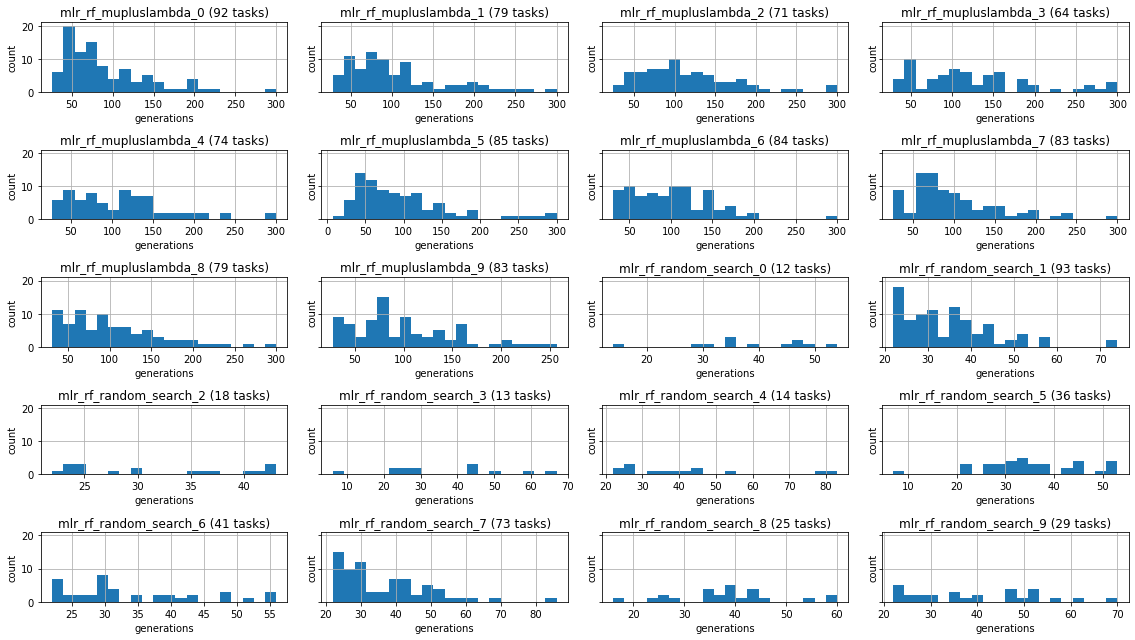

In [7]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(math.ceil(len(traces) / 4), 4, sharey=True, figsize=(16, 9))
for ax, (log, trace) in zip(axes.flatten(), traces.items()):
    traces[log].generations_by_task.hist(bins=20, ax=ax)
    ax.set_title(f"{log} ({len(trace.generations_by_task)} tasks)")
    ax.set_ylabel('count')
    ax.set_xlabel('generations')
fig.tight_layout()

The plot above shows a histogram counting the number of generations until stopping. These results were obtained with default setting of early stopping if no improvement was made after 20 generations, with a 200 generation maximum.

### Visualizing optimization traces
The traces contain the full optimization traces inside the trace's **progdf** trace.


In [8]:
# import seaborn as sns
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2'].progdf)
# sns.lineplot(x='gen', y='max', units='task', estimator=None, data=traces[f'{alg}_gauss24_1eph_d1_2i'].progdf)

### Comparing Expressions
For a given problem, we have a Pareto front of solutions for search (=each left out task).
This Pareto front may contain "twins", multiple solutions which performance equally well and have the same length.
Given that the response surface does not differ *that* much when leaving any particular task out, we hope that the symbolic expressions we find are reasonably consistent across searches.
To have some indication of how consistent the results are, for each problem we find the most frequent solutions of length 1, 2 and 3. We also note the number of hyperparameters for which we aim to find a symbolic default, as we expect this to be correlated to how consistent the solutions are:

In [9]:
expr_count = pd.DataFrame(np.zeros((5, len(traces))), columns=list(traces), index=[1, 2, 3, "#tasks", "params"])
for log, trace in traces.items():  
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            if length == 1:
                expr_count.loc["#tasks"][log] = len(trace.scores) / 2
                expr_count.loc["params"][log] = m.count(',') + 1
expr_count

,mlr_rf_mupluslambda_0,mlr_rf_mupluslambda_1,mlr_rf_mupluslambda_2,mlr_rf_mupluslambda_3,mlr_rf_mupluslambda_4,mlr_rf_mupluslambda_5,mlr_rf_mupluslambda_6,mlr_rf_mupluslambda_7,mlr_rf_mupluslambda_8,mlr_rf_mupluslambda_9,mlr_rf_random_search_0,mlr_rf_random_search_1,mlr_rf_random_search_2,mlr_rf_random_search_3,mlr_rf_random_search_4,mlr_rf_random_search_5,mlr_rf_random_search_6,mlr_rf_random_search_7,mlr_rf_random_search_8,mlr_rf_random_search_9
1,2.0,2.0,2.0,2.0,6.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
2,7.0,5.0,3.0,2.0,5.0,4.0,6.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.0,26.0,24.0,18.0,29.0,26.0,21.0,30.0,26.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#tasks,92.0,79.0,71.0,64.0,74.0,85.0,84.0,83.0,79.0,83.0,12.0,93.0,18.0,13.0,14.0,36.0,41.0,73.0,25.0,29.0
params,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


We can look at the found expressions per problem:

In [10]:
a = f'{alg}' # run_one #f"mlr_knn_lisa_gaussian" # run_one
for log, trace in traces.items():
    print(log)
    for length, expressions in sorted(trace.expressions.items()):
        if 0 < length < 4:
            m = max(set(expressions), key=expressions.count)
            expr_count.loc[length][log] = expressions.count(m)
            # print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")
            print(f"Most frequent length {length} solution in Pareto front ({expressions.count(m)} times in {len(trace.scores) // 2} tasks):\n     {m}")

mlr_rf_mupluslambda_0
Most frequent length 1 solution in Pareto front (2 times in 92 tasks):
     make_tuple(p, n, 5)
Most frequent length 2 solution in Pareto front (7 times in 92 tasks):
     make_tuple(m, expit(xvar), 5)
Most frequent length 3 solution in Pareto front (32 times in 92 tasks):
     make_tuple(expit(xvar), expit(mcp), 5)
mlr_rf_mupluslambda_1
Most frequent length 1 solution in Pareto front (2 times in 79 tasks):
     make_tuple(n, po, 5)
Most frequent length 2 solution in Pareto front (5 times in 79 tasks):
     make_tuple(n, expit(xvar), 5)
Most frequent length 3 solution in Pareto front (26 times in 79 tasks):
     make_tuple(expit(xvar), expit(mcp), 5)
mlr_rf_mupluslambda_2
Most frequent length 1 solution in Pareto front (2 times in 71 tasks):
     make_tuple(n, p, 5)
Most frequent length 2 solution in Pareto front (3 times in 71 tasks):
     make_tuple(po, expit(xvar), 5)
Most frequent length 3 solution in Pareto front (24 times in 71 tasks):
     make_tuple(expit(

## Expression Quality
The expressions we find also need to be good.
Here we compare the following 'strategies':
 - length-*n*: always pick the best expression of length *n*
 - *final*: always pick the best expression, regardless of length
 - *baseline(s)*: compare it to baselines we defined
 
We want to know (all based on out-of-sample performance):
 - which strategy gives the best solution most often?
 - which strategy experiences the least mean regret?
 - which strategy experiences the least median regret?
 
As mentioned before, there can be "twins" in the Pareto front, which means multiple solutions with equal length have equal in-sample performance.
In this case we average the out-of-sample score of those twins.

#### number of wins:

The following table records the number of times a strategy led to the symbolic expression with the best out-of-sample performance (multiple strategies can be the best each task):

In [11]:
out_comparisons = pd.DataFrame()
for log, trace in traces.items():
    out_comparisons = out_comparisons.append(trace.comparison.loc['either'].rename(log))
out_comparisons

,final,length-1,length-2,length-3,mlr_default
mlr_rf_mupluslambda_0,41.0,14.0,25.0,19.0,13.0
mlr_rf_mupluslambda_1,32.0,6.0,20.0,24.0,14.0
mlr_rf_mupluslambda_2,29.0,10.0,19.0,22.0,11.0
mlr_rf_mupluslambda_3,26.0,7.0,13.0,21.0,9.0
mlr_rf_mupluslambda_4,25.0,11.0,23.0,22.0,9.0
mlr_rf_mupluslambda_5,42.0,7.0,22.0,21.0,14.0
mlr_rf_mupluslambda_6,34.0,8.0,25.0,23.0,13.0
mlr_rf_mupluslambda_7,32.0,13.0,24.0,15.0,14.0
mlr_rf_mupluslambda_8,35.0,10.0,24.0,22.0,11.0
mlr_rf_mupluslambda_9,28.0,11.0,25.0,22.0,19.0


## Regret
Here we look at the regret for a method compared to the best known performance on the dataset from the random search experiments. Per definition the best score in random search is 1 (normalized score).

#### median regret:
The following table records the median regret for a specific strategy compared to picking the best in hindsight:

In [66]:
fewest_completions = min(traces.values(), key=lambda t: len(t.scores))
fewest_completions)

AttributeError: 'Trace' object has no attribute 'name'

In [50]:
medians = {}
for log, trace in traces.items():
    idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] < 25)
    medians[log] = [(1 - trace.scores[idx].final).median()]
    
medians["mlr_default"] = [(1 - trace.scores[idx].mlr_default).median()]
pd.DataFrame.from_dict(medians, orient='index')

,0
mlr_rf_mupluslambda_0,0.0164
mlr_rf_mupluslambda_1,0.0148
mlr_rf_mupluslambda_2,0.0134
mlr_rf_mupluslambda_3,0.0127
mlr_rf_mupluslambda_4,0.0104
mlr_rf_mupluslambda_5,0.0117
mlr_rf_mupluslambda_6,0.0102
mlr_rf_mupluslambda_7,0.0134
mlr_rf_mupluslambda_8,0.0140
mlr_rf_mupluslambda_9,0.0157


In [52]:
means = {}
for log, trace in traces.items():
    idx = trace.scores.index.map(lambda idx: idx[1] == "out-sample" and idx[0] < 25)
    means[log] = [(1 - trace.scores[idx].final).mean()]
    
means["mlr_default"] = [(1 - trace.scores[idx].mlr_default).mean()]
pd.DataFrame.from_dict(means, orient='index')

,0
mlr_rf_mupluslambda_0,0.038000
mlr_rf_mupluslambda_1,0.038609
mlr_rf_mupluslambda_2,0.041309
mlr_rf_mupluslambda_3,0.043309
mlr_rf_mupluslambda_4,0.039755
mlr_rf_mupluslambda_5,0.042491
mlr_rf_mupluslambda_6,0.038509
mlr_rf_mupluslambda_7,0.038318
mlr_rf_mupluslambda_8,0.037836
mlr_rf_mupluslambda_9,0.038800


### Sanity Checks
Sometimes out-of-sample performance of a baseline may still be better than that of our solution.
However, in-sample performance of our own solutions should always be better than any baseline.
If that is not the case, this would indicate our search does not explore the space well enough.

In [53]:
in_sample_comparisons = pd.DataFrame()
for log, trace in traces.items():
    in_sample_comparisons = in_sample_comparisons.append(trace.in_comparison.loc['either'].rename(log))
in_sample_comparisons

,final,length-1,length-2,length-3,mlr_default
mlr_rf_mupluslambda_0,92.0,0.0,7.0,15.0,0.0
mlr_rf_mupluslambda_1,79.0,0.0,6.0,9.0,0.0
mlr_rf_mupluslambda_2,71.0,0.0,3.0,11.0,0.0
mlr_rf_mupluslambda_3,64.0,0.0,3.0,9.0,0.0
mlr_rf_mupluslambda_4,74.0,0.0,2.0,11.0,0.0
mlr_rf_mupluslambda_5,84.0,0.0,6.0,14.0,0.0
mlr_rf_mupluslambda_6,84.0,0.0,5.0,11.0,0.0
mlr_rf_mupluslambda_7,83.0,0.0,8.0,11.0,0.0
mlr_rf_mupluslambda_8,79.0,1.0,3.0,18.0,0.0
mlr_rf_mupluslambda_9,83.0,0.0,6.0,15.0,0.0


In [15]:
traces.keys()

dict_keys(['mlr_rf_mupluslambda_0', 'mlr_rf_mupluslambda_1', 'mlr_rf_mupluslambda_2', 'mlr_rf_mupluslambda_3', 'mlr_rf_mupluslambda_4', 'mlr_rf_mupluslambda_5', 'mlr_rf_mupluslambda_6', 'mlr_rf_mupluslambda_7', 'mlr_rf_mupluslambda_8', 'mlr_rf_mupluslambda_9', 'mlr_rf_random_search_0', 'mlr_rf_random_search_1', 'mlr_rf_random_search_2', 'mlr_rf_random_search_3', 'mlr_rf_random_search_4', 'mlr_rf_random_search_5', 'mlr_rf_random_search_6', 'mlr_rf_random_search_7', 'mlr_rf_random_search_8', 'mlr_rf_random_search_9'])

In [16]:
ml = traces['mlr_rf_mupluslambda_0']
rs = traces['mlr_rf_random_search_0']

In [17]:
ml.scores.head(25)

length-1  length-2  length-3   final  mlr_default
task sample-type                                                   
3    in-sample      0.8953    0.9145    0.9183  0.9183       0.8524
     out-sample     0.9950    0.9808    0.9917  0.9917       0.9992
6    in-sample      0.8699    0.9076    0.9155  0.9179       0.8530
     out-sample     0.9319    0.9786    0.9946  0.9786       0.9312
11   in-sample      0.8963    0.9156    0.9164  0.9192       0.8540
     out-sample     0.8617    0.8755    0.8835  0.8835       0.8103
12   in-sample      0.8698    0.9075    0.9182  0.9182       0.8529
     out-sample     0.9397    0.9898    0.9899  0.9899       0.9382
14   in-sample      0.8697    0.9038    0.9158  0.9183       0.8528
     out-sample     0.9579    0.9936    0.9896  0.9946       0.9550
15   in-sample      0.8958    0.9146    0.9158  0.9176       0.8530
     out-sample     0.9487    0.9618    0.9666  0.9610       0.9233
16   in-sample      0.8959    0.9146       NaN  0.9146       0.8530
     out-sample     0.9410    0.9836       NaN  0.9836       0.9257
18   in-sample      0.8955    0.9139    0.9156  0.9174       0.8527
     out-sample     0.9843    0.9816    0.9810  0.9746       0.9640
22   in-sample      0.8957    0.9147    0.9159  0.9223       0.8527
     out-sample     0.9637    0.9825    0.9859  0.9929       0.9604
23   in-sample      0.8721    0.9096    0.9168  0.9201       0.8552
     out-sample     0.6721    0.7365    0.8455  0.8316       0.6688
24   in-sample      0.8957    0.9145    0.9149  0.9150       0.8528
     out-sample     0.9617    1.0000    1.0000  1.0000       0.9450
2073 in-sample      0.8959    0.9149    0.9158  0.9195       0.8531
     out-sample     0.9369    0.9566    0.9634  0.9651       0.9112
2074 in-sample      0.8955    0.9146    0.9166  0.9180       0.8525

In [18]:
rs.scores

length-1  length-2  length-3   final  mlr_default
task sample-type                                                   
3    in-sample      0.8804       NaN       NaN  0.9076       0.8524
     out-sample     0.9980       NaN       NaN  0.9857       0.9992
6    in-sample      0.8845       NaN       NaN  0.9078       0.8530
     out-sample     0.8469       NaN       NaN  0.9793       0.9312
11   in-sample      0.8863       NaN       NaN  0.9089       0.8540
     out-sample     0.8583       NaN       NaN  0.8184       0.8103
12   in-sample      0.8853       NaN       NaN  0.9110       0.8529
     out-sample     0.9610       NaN       NaN  0.9898       0.9382
14   in-sample      0.8936       NaN       NaN  0.9127       0.8528
     out-sample     0.9531       NaN       NaN  0.9896       0.9550
15   in-sample      0.8841       NaN       NaN  0.9085       0.8530
     out-sample     0.9430       NaN       NaN  0.9643       0.9233
16   in-sample      0.8830       NaN       NaN  0.9120       0.8530
     out-sample     0.9366       NaN       NaN  0.9840       0.9257
18   in-sample      0.8832       NaN       NaN  0.9086       0.8527
     out-sample     0.9744       NaN       NaN  0.9831       0.9640
22   in-sample      0.8791       NaN       NaN  0.9093       0.8527
     out-sample     0.9651       NaN       NaN  0.9849       0.9604
23   in-sample      0.8857       NaN       NaN  0.9149       0.8552
     out-sample     0.8125       NaN       NaN  0.7826       0.6688
24   in-sample      0.8892       NaN       NaN  0.9074       0.8528
     out-sample     0.9673       NaN       NaN  0.9969       0.9450
2073 in-sample         NaN       NaN       NaN     NaN          NaN
     out-sample        NaN       NaN       NaN     NaN          NaN

In [19]:
rs.d_scores

,,length-1,length-2,length-3,final,mlr_default,max,d_length-1,d_length-2,d_length-3,d_final,d_mlr_default,d_max
task,sample-type,,,,,,,,,,,,
3,out-sample,0.9980,NaN,NaN,0.9857,0.9992,0.9992,0.0012,NaN,NaN,0.0135,0.0000,0.0
6,out-sample,0.8469,NaN,NaN,0.9793,0.9312,0.9793,0.1324,NaN,NaN,0.0000,0.0481,0.0
11,out-sample,0.8583,NaN,NaN,0.8184,0.8103,0.8583,0.0000,NaN,NaN,0.0399,0.0480,0.0
12,out-sample,0.9610,NaN,NaN,0.9898,0.9382,0.9898,0.0288,NaN,NaN,0.0000,0.0516,0.0
14,out-sample,0.9531,NaN,NaN,0.9896,0.9550,0.9896,0.0365,NaN,NaN,0.0000,0.0346,0.0
15,out-sample,0.9430,NaN,NaN,0.9643,0.9233,0.9643,0.0213,NaN,NaN,0.0000,0.0410,0.0
16,out-sample,0.9366,NaN,NaN,0.9840,0.9257,0.9840,0.0474,NaN,NaN,0.0000,0.0583,0.0
18,out-sample,0.9744,NaN,NaN,0.9831,0.9640,0.9831,0.0087,NaN,NaN,0.0000,0.0191,0.0
22,out-sample,0.9651,NaN,NaN,0.9849,0.9604,0.9849,0.0198,NaN,NaN,0.0000,0.0245,0.0


### Comparison to random search 
The following provides an overview over scores for different iterations of random search

In [20]:
name = "mlr_svm"
rsdf = pd.read_csv("data/"+name+"_baselines.csv", index_col=0)
rsdf.iloc[:,1:].apply(np.mean,axis=1)

search_type
oracle    1.000000
rs_2      0.678134
rs_4      0.797459
rs_8      0.884290
rs_16     0.930003
rs_32     0.953510
rs_64     0.966905
rs_128    0.977901
dtype: float64

----
End of notebook - just sketchpad below

In [21]:
alg

'rf'

In [22]:
trace.scores.isna().any(axis=0)

length-1       False
length-2        True
length-3        True
final          False
mlr_default     True
dtype: bool

In [23]:
alg = "svm"
run_one = "mlr_svm_lisa"
minimum = dict(knn=100, svm=100, glmnet=100, rpart=60)
final_scores = pd.DataFrame()
for log, trace in traces.items():
    # Filter out runs with >100 tasks completed:
    if len(trace.scores) / 2 > minimum[alg]:
        out_sample = trace.scores.index.map(lambda idx: idx[1] == "out-sample")
        log_oos = trace.scores.loc[out_sample].final.rename(log)
        final_scores = final_scores.append(log_oos)
        if log == run_one:
            # contains benchmark scores
            for b in trace.baseline:
                baseline_score = trace.scores.loc[out_sample][b].rename(b)
                final_scores = final_scores.append(baseline_score)
final_scores

""


In [24]:
# filter out incomplete tasks:
final = final_scores.loc[:, ~final_scores.isna().any()]
df = final

In [25]:
run_one="mlr_svm_lisa"
run_two="svm_warm"

In [26]:
df = df.loc[[run_one, run_two]]

KeyError: "None of [Index(['mlr_svm_lisa', 'svm_warm'], dtype='object')] are in the [index]"

In [ ]:
alone = {k: 0 for k in df.index.values}
shared = {k: 0 for k in df.index.values}

for _, out in df.T.iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted({**alone, **shared})}
comparison = pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])
comparison


In [ ]:
df_out = df.T.copy()
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_' + col] = df_out['max'] - df_out[col]
d_cols = [c for c in df_out.columns if c.startswith('d_') and 'max' not in c]
df_out[d_cols].mean()

In [ ]:
df_out[d_cols].median()

In [ ]:
ax = (df.loc[run_one] - df.loc[run_two]).hist(bins=[(f / 40 - 1) for f in range(81)])
ax.set_title(f"Symbolic - Constant | median: {(df.loc[run_one] - df.loc[run_two]).median():.3f}, mean: {(df.loc[run_one] - df.loc[run_two]).mean():.3f}, {df.shape[1]} tasks")
ax.set_ylabel("Count")
ax.set_xlabel("Difference")

In [ ]:
sum((df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]) > 0)

In [ ]:
(df.loc["mlr_svm_lisa"] - df.loc["svm_cst"]).mean()

In [ ]:
rsdf.columns = [(round(float(x)), 'out-sample')  for x in rsdf.columns.values

In [ ]:
df = rsdf.append(final_scores)
df.iloc[:,1:].apply(np.mean,axis=1)

In [ ]:
pdf = df.transpose().melt(var_name="method", value_name="performance")
ax = sns.boxplot(x='method', y='performance', data = pdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#### mean regret:
The following table records the mean regret for a specific strategy compared to picking the best in hindsight:

In [13]:
means = pd.DataFrame([])
for log, trace in traces.items():
    m = trace.d_scores.mean().rename(log)
    means = means.append(m)
means[[c for c in medians.columns if 'd_' in c and c != 'd_max']]

,d_final,d_length-1,d_length-2,d_length-3,d_mlr_default
mlr_rf_mupluslambda_0,0.013933,0.029902,0.010628,0.014247,0.058411
mlr_rf_mupluslambda_1,0.008670,0.047190,0.016870,0.013175,0.064472
mlr_rf_mupluslambda_2,0.022906,0.033299,0.016063,0.027273,0.055931
mlr_rf_mupluslambda_3,0.012478,0.037078,0.014622,0.015216,0.049202
mlr_rf_mupluslambda_4,0.016131,0.050892,0.017968,0.014053,0.061789
mlr_rf_mupluslambda_5,0.009529,0.043040,0.016358,0.011363,0.059170
mlr_rf_mupluslambda_6,0.010135,0.043105,0.019482,0.015928,0.063792
mlr_rf_mupluslambda_7,0.013692,0.043280,0.011275,0.011811,0.060270
mlr_rf_mupluslambda_8,0.014550,0.039845,0.015468,0.016192,0.067832
mlr_rf_mupluslambda_9,0.013627,0.033307,0.013841,0.013992,0.064271
